<a href="https://colab.research.google.com/github/Snrts/PRA3024_BigDataInPhysics_SanneAarts/blob/Week_4/SanneAartsML2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The cartPole
### Action space
<ul>
<li>push left - 0</li>
<li>push right - 1</li>
</ul>

### Observation space
|num|Observation|Variable|Values|Episode terminates for:|
|-|-|-|-|-|
|0|Cart position|$x$|$\pm$ 4.8|$\lvert x \rvert > 2.4$|
|1|Cart Velocity|$\dot{x}$|$\pm \infty$||
|2|Pole Angle|$\theta$|$\pm$ 24 $^ \circ$|$\lvert \theta \rvert > 12 ^\circ $|
|3|Pole Angular Velocity|$\dot{\theta}$|$\pm\infty$||


In [2]:
import gym
import numpy as np
from matplotlib import pyplot as plt
import random

from collections import deque
from keras.models import Sequential, load_model
from keras.layers import Dense,  Flatten
from keras.optimizers import Adam, RMSprop
import os


#### Bellman Equation

\begin{equation}
Q_{new}(s, a)=Q(s,a)+\alpha \left[ r(s,a)+ \gamma * max_{a'}(Q'(s',a'))-Q(s,a)\right] \hspace{1em}
\begin{array}{rl}
Q_{new}:& \text{New Q value}\\
Q:& \text{Current Q value}\\
s:& \text{State}\\
a:& \text{Action}\\
\alpha:& \text{Learning Rate}\\
r:& \text{reward}\\
\gamma:& \text{Discount rate}\\
max(Q'(s',a')):& \text{Maximum expected future reward}\\
\end{array} 
\tag{1}
\end{equation}
#### Loss function

\begin{equation}
L=\frac{1}{2}\left[r+\gamma max_{a'}(Q'(s',a'))-Q(s,a) \right]^2 
\tag{2}
\end{equation}

In [15]:
class DQNagent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=100000)

        self.gamma = 0.95
        self.exploration_rate = 1.0
        self.exploration_rate_decay = 0.995
        self.exploration_rate_min = 0.01
        self.learning_rate = 0.001
        self.batch_size = 1
        self.episodes = 50
        
        self.model = self.build_model()
        self.target_update_freq = 100
        self.target_model = self.build_model()
        # self.update_target_model()
        
        self.history = []
        self.loss = []
        
    def build_model(self):
        # Building Network
        # Create a Sequential model using keras
        model = Sequential()
        #Input - 4 different states 
        model.add(Dense(32, activation='relu', input_shape=(self.state_size,)))
        # model.add(Flatten(input_shape=(1,self.state_size)))
        model.add(Dense(32, activation='relu'))
        # Output - one node for each possible action, the one with the 
        # highest output value will be be returned as action
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done): 
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        # Greedy Epsilon policy, a random number between 0 and 1 is selected, if the number is smaller
        # than the exploration rate,a random action is selected from the available actions
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        # otherwise the action with the highest predicted Q-value is selected 
        # state is passed into the predict method to get the predicted Q value for
        # all possible actions (here, to go left or right)
        act_values = self.model.predict(state)
        # since we get two outputs, we want to select the action corresponding to the highest value
        return np.argmax(act_values[0])
    
    def decay_exploration(self):
        if self.exploration_rate > self.exploration_rate_min:
            self.exploration_rate *= self.exploration_rate_decay
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        
        minibatch = random.sample(self.memory, self.batch_size)
        
        for state, action, reward, next_state, terminal in minibatch:
            q_update = reward
            
            if not terminal:
                q_update = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            
            q_value = self.model.predict(state)
            q_value[0][action] = q_update
            self.model.fit(state, q_value, epochs=1, verbose=0)
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)
    
    # def update_target_model(self):
    #     self.target_model.set_weights(self.model.get_weights())
    
    def save(self):
        self.model.save_weights('dqn_weights.h5f', overwrite=True)
        # self.model.save_weights(name)
    
    def test(self,test_episodes = 100):
        env_test = gym.make('CartPole-v1')

        # Load the saved model weights
        model = Sequential([
            Dense(32, activation='relu', input_dim=env_test.observation_space.shape[0]),
            Dense(32, activation='relu'),
            Dense(env_test.action_space.n, activation=None)
        ])
        model.load_weights('dqn_weights.h5f')

        # Set the epsilon value to zero for testing
        explorationrate  = 0.05

        # Run the test loop for 10 episodes
        test_episodes = 10
        test_rewards = []
        for i in range(test_episodes):
            state = env_test.reset()
            done = False
            ep_reward = 0
            while not done:
                # Use the learned policy to select actions
                q_values = model.predict(np.array([state]))[0]
                action = np.argmax(q_values)
                # Take the action and observe the new state and reward
                state, reward, done, _ = env_test.step(action)
                # Update the episode reward
                ep_reward += reward
            # Append the episode reward to the list of test rewards
            test_rewards.append(ep_reward)

        # Print the average reward obtained over all test episodes
        plt.plot(range(test_episodes), test_rewards)
        plt.axhline(sum(test_rewards)/len(test_rewards))
    



In [12]:
class cartpole:
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.agent = DQNagent(self.state_size,self.action_size)
        self.episodes = 50
        self.batch_size=1
        self.episode_rewards = deque(maxlen=300)
        self.runsteplog = []   
    def metrics(self):
        for episode in range(self.episodes):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            steps = 0
            totalreward = 0
            done = False
            while not done:
                steps += 1
                action = self.agent.act(state)
                next_state, reward, done, _ = self.env.step(action)
                
                reward = reward if not done else - reward
                next_state = np.reshape(next_state, [1, self.state_size])
                # self.agent.decay_exploration()
                self.agent.remember(state, action, reward, next_state, done)
                totalreward += reward
                
                state = next_state
                
                if done:
                    print("episode: {}/{}, score: {}, e: {:.2}".format(episode, self.episodes, totalreward, self.agent.exploration_rate))
                    self.runsteplog.append(steps)
                    self.episode_rewards.append(totalreward)
                    break
                if len(self.agent.memory) > self.batch_size: 
                    self.agent.replay()
    
    def plott(self):
        # fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=2, ncols=2)

        plt.plot(self.runsteplog)
        plt.ylabel("# actions before terminal")
        plt.xlabel("run iteration")

    def test(self):
        self.agent.test()
    #     success_measure = np.mean(runsteplog[-15:])
    #     print("Mean of last 15 runs: {0}".format(success_measure))
        
    #     agent.save("weights")

In [13]:
mod = cartpole()
mod.metrics()
# mod.agent.history
# mod.history

1/1 [==============================] - 0s 54ms/step


c:\Users\Sanne\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 22ms/step
episode: 0/10, score: 22.0, e: 0.9
1/1 [==============================] - 0s 20ms/step
episode: 1/10, score: 27.0, e: 0.78
1/1 [==============================] - 0s 21ms/step
episode: 2/10, score: 9.0, e: 0.74
1/1 [==============================] - 0s 20ms/step
episode: 3/10, score: 12.0, e: 0.69
1/1 [==============================] - 0s 19ms/step
episode: 4/10, score: 8.0, e: 0.66
1/1 [==============================] - 0s 22ms/step
episode: 5/10, score: 23.0, e: 0.59
1/1 [==============================] - 0s 19ms/step
episode: 6/10, score: 48.0, e: 0.46
1/1 [==============================] - 0s 20ms/step
episode: 7/10, score: 52.0, e: 0.35
1/1 [==============================] - 0s 21ms/step
episode: 8/10, score: 38.0, e: 0.29
1/1 [==============================] - 0s 19ms/step
episode: 9/10, score: 8.0, e: 0.28


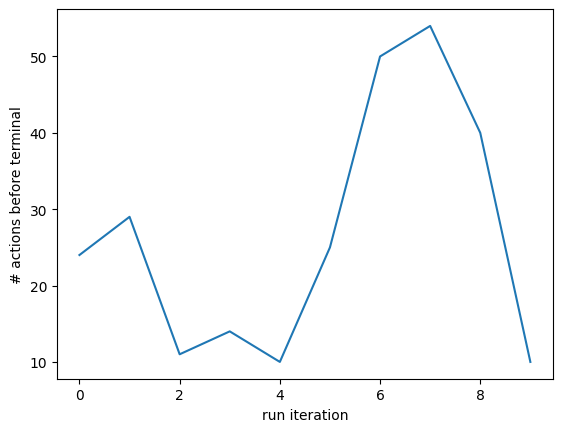

In [14]:
mod.plott()

## Agent

$$loss=\left(r+\gamma max \hat{Q}(s,a')-Q(s,a\right)^2$$